# K-means Top 10 Recomendations

Pre-Processing

In [9]:
# Import Libraries
from sklearn import metrics
import pandas as pd
import numpy as np
from pyparsing import col
from requests import head
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from torch import rand
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [18]:
#Read in data 
u = 'data/ml-100k/'

# User data
df = pd.read_csv(u+'u.data', sep='\t', header=None)
df.columns = ['user_id', 'item_id', 'rating', 'timestamp']

# Users
users = pd.read_csv(u+'u.user', sep='|', header=None)
users.columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

# genre data
genre = pd.read_csv(u+'u.genre', sep='|', header=None)
genre.columns = ['genre', 'genre_id']

# occupation data
job = pd.read_csv(u+'u.occupation', sep='|', header=None)
job.columns = ['occupation']
job = job.reset_index().rename(columns={'index': 'job'})

# other items
items = pd.read_csv(u+'u.item', sep='|', header=None)
items.columns = ['movie_id', 'movie_title', 'video_release_date', 
                 'imdb_url', 'unknown', 'Action', 'Adventure', 
                 'Animation','Children', 'Comedy', 'Crime', 
                 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 
                 'Horror', 'Musical', 'Mystery', 'Romance', 
                 'Sci_Fi', 'Thriller', 'War', 'Western']

In [20]:
#Combine/clean data

data = df.merge(users, how='left', on = 'user_id').merge(job, how = 'left', on='occupation').merge(items, how='left', left_on='item_id', right_on='movie_id')
data[data.Western.isna()]
data = data[data.Western.notna()].astype({'Western': 'int'})
data.gender.unique()
data['gender_id'] = np.where(data.gender == 'M', 0, 1)


movie_data = data[['user_id', 'movie_title', 'rating']]
#movie_data

data

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,job,movie_id,...,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,gender_id
0,196,242,3,881250949,49,M,writer,55105,20,242,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,39,F,executive,00000,6,302,...,1,0,0,1,0,0,1,0,0,1
2,22,377,1,878887116,25,M,writer,40206,20,377,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,28,M,technician,80525,19,51,...,0,0,0,0,1,0,0,1,1,0
4,166,346,1,886397596,47,M,educator,55113,3,346,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,880,476,3,880175444,13,M,student,83702,18,476,...,0,0,0,0,0,0,0,0,0,0
99996,716,204,5,879795543,36,F,administrator,44265,0,204,...,0,0,0,0,0,1,0,0,0,1
99997,276,1090,1,874795795,21,M,student,95064,18,1090,...,0,0,0,0,0,0,1,0,0,0
99998,13,225,2,882399156,47,M,educator,29206,3,225,...,0,0,0,0,0,0,0,0,0,0


(943, 1663)
(943, 118)
(35, 118)


movie_title,2001: A Space Odyssey (1968),Air Force One (1997),Aladdin (1992),Alien (1979),Aliens (1986),Amadeus (1984),Apocalypse Now (1979),Apollo 13 (1995),Babe (1995),Back to the Future (1985),...,True Lies (1994),"Truth About Cats & Dogs, The (1996)",Twelve Monkeys (1995),Twister (1996),"Usual Suspects, The (1995)",Volcano (1997),When Harry Met Sally... (1989),Willy Wonka and the Chocolate Factory (1971),"Wizard of Oz, The (1939)",Young Frankenstein (1974)
user_id,,,,,,,,,,,,,,,,,,,,,
7,5.0,4.0,NaN,4.0,3.0,5.0,5.0,5.0,5.0,5.0,...,5.0,NaN,5.0,2.0,5.0,3.0,4.0,4.0,5.0,5.0
13,5.0,1.0,5.0,4.0,3.0,3.0,5.0,5.0,4.0,5.0,...,3.0,5.0,2.0,4.0,5.0,3.0,3.0,NaN,4.0,5.0
59,5.0,NaN,2.0,5.0,5.0,4.0,4.0,5.0,NaN,5.0,...,4.0,4.0,4.0,5.0,5.0,NaN,4.0,5.0,5.0,5.0
92,4.0,NaN,3.0,4.0,5.0,4.0,5.0,3.0,5.0,4.0,...,4.0,3.0,4.0,2.0,5.0,2.0,3.0,NaN,3.0,4.0
94,4.0,NaN,NaN,5.0,4.0,5.0,5.0,4.0,5.0,4.0,...,2.0,4.0,4.0,3.0,4.0,NaN,3.0,5.0,4.0,4.0


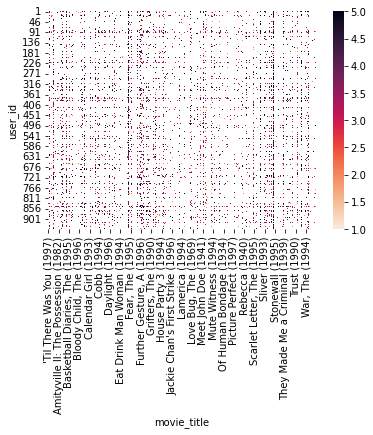

In [23]:
data_matrix = movie_data.pivot_table(index="user_id", columns="movie_title", values="rating")
print(data_matrix.shape)
ax = sns.heatmap(data_matrix, fmt="d", cmap="rocket_r")

# drop movies/columns with more than 30 NaN
data_matrix = data_matrix.dropna(thresh=200, axis=1)
print(data_matrix.shape)

# drop users/rows with more than 30 NaN
data_matrix = data_matrix.dropna(thresh=90, axis=0)
print(data_matrix.shape)

data_matrix.head()

In [ ]:
# convert all NaNs to 0.0
data_matrix = data_matrix.fillna(0)
data_matrix.head()

# standardize the ratings so the mean is now zero. negative reviews are - and positive reviews are positive
def standardize(row):
    new_row = (row - row.mean()) / (row.max() - row.min())
    return new_row

std_data_matrix = data_matrix.apply(standardize)
std_data_matrix.head()

In [ ]:
ax = sns.heatmap(std_data_matrix, fmt="d", cmap="rocket_r")

In [ ]:
# https://www.youtube.com/watch?v=3ecNC-So0r4

from sklearn.metrics.pairwise import cosine_similarity

# will calculate the similarity ROW-WISE
# user-user collaborative filtering will be row-wise
# item-item collaborative filtering will need to be transposed
item_similarity = cosine_similarity(std_data_matrix)
item_similarity = pd.DataFrame(item_similarity, 
                               index= std_data_matrix.index, 
                               columns=std_data_matrix.index)
item_similarity

In [ ]:
def get_similar_movies(movie_name, rating, n):
    similar_score = item_similarity[movie_name]*(rating)#-2.5)
    similar_score = similar_score.sort_values(ascending=False)
    
    return similar_score[:10]

print(get_similar_movies(7,4, 10))

In [ ]:
for movie, ra

In [ ]:
from sklearn.cluster import KMeans

predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(data_matrix)